# This is the driver program for the ARIMA process. 

- It starts with testing stationarity.
- Then it runs a grid search for the best parameters. It returns the best parameters and we use those going forward.
- Then we summarize residual errors for the model.
- Then we summarize residual errors from bias corrected forecasts.
- Plots test vs prediction scores
- Saves finalized model to file
- Loads the finalized model and makes a prediction. This proves that it works.
- Then finally we forecast for the balance of the year.

## Update the John Hopkins, Covid-19 data 
https://github.com/CSSEGISandData/COVID-19 by refreshing your local copy of the GitHub repository. 

In [1]:
# import libraries
import numpy as np
import pandas as pd
import pickle
import stationarity as st
import load_data as ld
import arima_grid_search as ags
import summarize
import test_prediction_save_forecast_1day as tpsf1
import multi_step_forecast as msf

## Prepare arguments for driver

In [2]:
arg_dict = {'file_name_1': r'data\all_df.csv',
            'file_name_2': r'C:\Users\linds\OneDrive\mystuff\GitHub\covid\data\country_codes_edited.csv',
            'feature': 'Alpha_3',
            'place': 'USA',
            'dependent_variable': 'Deaths',
            'path': r'C:\Users\linds\OneDrive\mystuff\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports',
            'best_cfg': (7,2,2), 
            'order_list': [],
            'p_values': range(6,8),
            'd_values': range(1,3),
            'q_values': range(1,3),
            'split_value': .5,
            'bias': 0, # First time thru bias is 0
            'date': '12-31-2020'}

## Load John Hopkins data

The "data date" is 2020-08-30 00:00:00

ADF Statistic: -2.379655
p-value: 0.147561
Critical Values:
	1%: -3.469
	5%: -2.878
	10%: -2.576


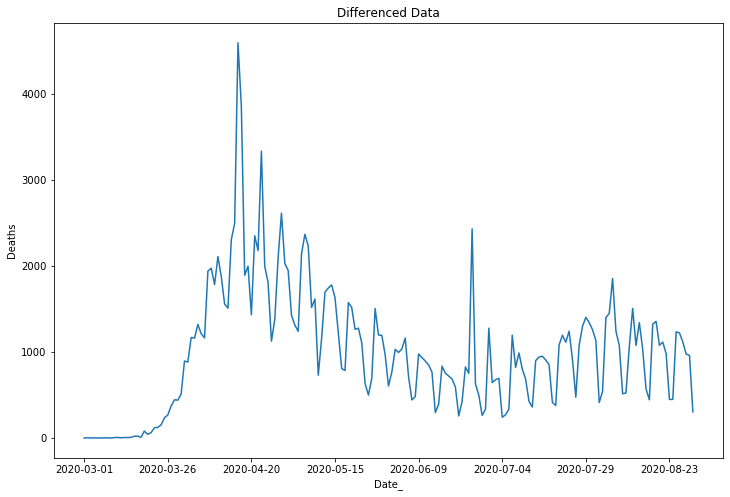

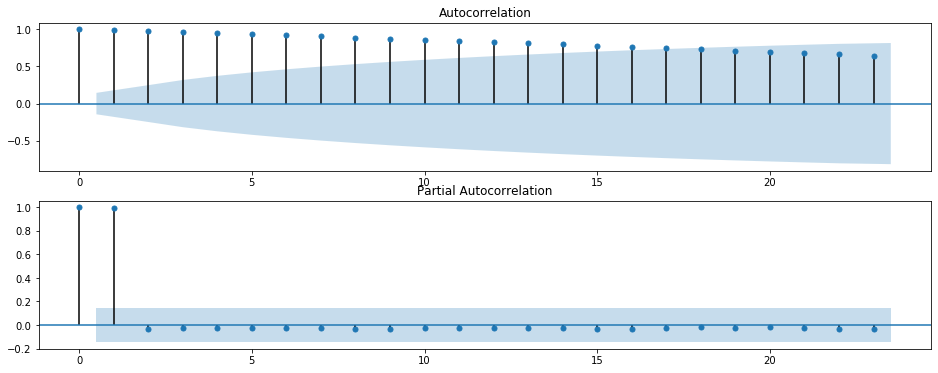

RMSE is 349.348 with ARIMA of (6, 2, 1)
RMSE is 337.235 with ARIMA of (7, 1, 1)
RMSE is 329.89 with ARIMA of (7, 2, 1)

Best RMSE Score is 329.89 with ARIMA of (7, 2, 1)

RMSE: 329.890
       Residual Statistics
count            92.000000
mean             -5.885071
std             331.645258
min           -1012.930142
25%            -195.259181
50%             -10.696937
75%             156.538121
max            1696.547290


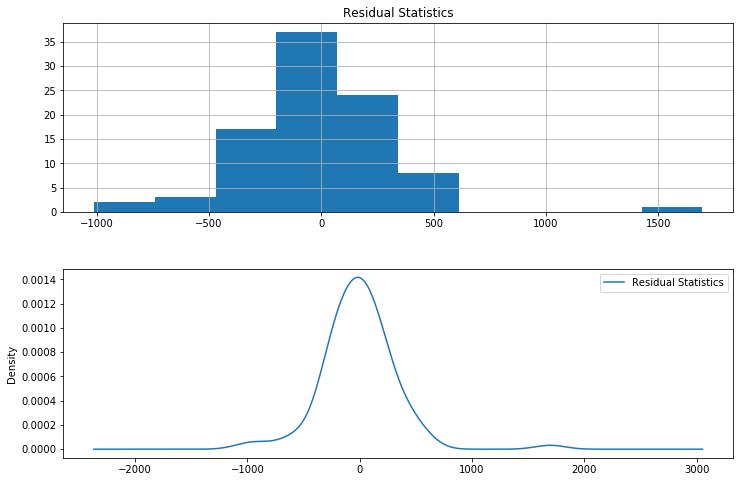


bias IS saved in arg_dict["bias"] for subsequent run is: -5.88507141689036 


RMSE: 329.838
       Residual Statistics
count         9.200000e+01
mean         -4.112498e-12
std           3.316453e+02
min          -1.007045e+03
25%          -1.893741e+02
50%          -4.811866e+00
75%           1.624232e+02
max           1.702432e+03


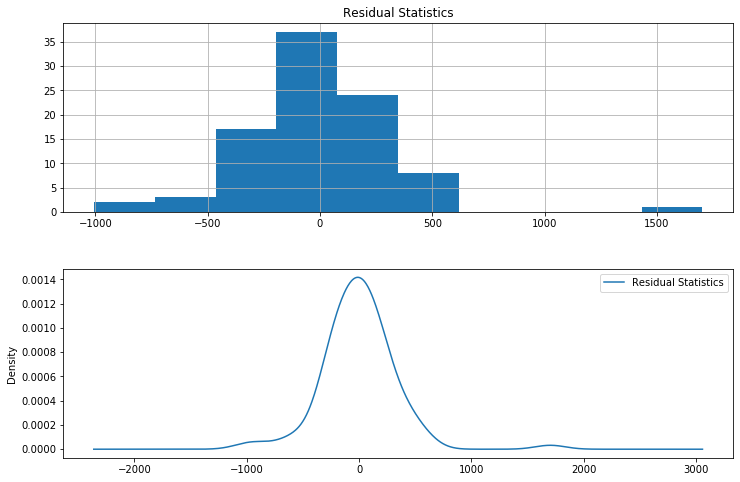


bias NOT saved in arg_dict["bias"] for subsequent run is: -4.112497781929762e-12 



In [3]:
df, li_set = ld.driver(arg_dict)

# Get the date of the last row in the file to establish the currency of the data.
print(f'The "data date" is {df["Date_"].iloc[-1]}\n')

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test for stationarity
df = st.driver(arg_dict)

# save df for subsequent independent processing
df.to_csv('df.csv')
      
# Grid search ARIMA parameters 
order_list = ags.driver(df, arg_dict)
arg_dict.update({'order_list': order_list})
arg_dict.update({'best_cfg': order_list[0]})

# summarize residual errors for an ARIMA model and return bias
model_fit, test, predictions = summarize.driver(df, arg_dict)

# Rerun summarize, as bias adjusted
model_fit, test, predictions = summarize.driver(df, arg_dict)
arg_dict.update({'test': test, 'predictions': predictions, 'model_fit': model_fit})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


## Plot test (actual) vs predictions, save, and forecast

The predicted cumulative Deaths for USA for tomorrow (input data plus 1 day) are 183,406


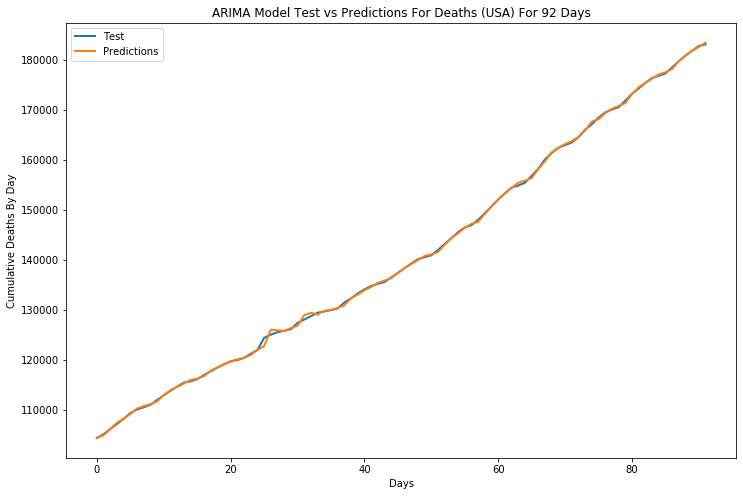

In [4]:
tpsf1.driver(arg_dict)

NB The above prediction of a single day in the future will only rarely match the the first day in the multi step forecast below. The reason is that the ARIMA model is a moving average model. The specific days included in the moving average change in the multi step forecast. 

## Multi step forecast

The USA prediction is for 309,962 cumulative Deaths to occur by 2020-12-31 00:00:00


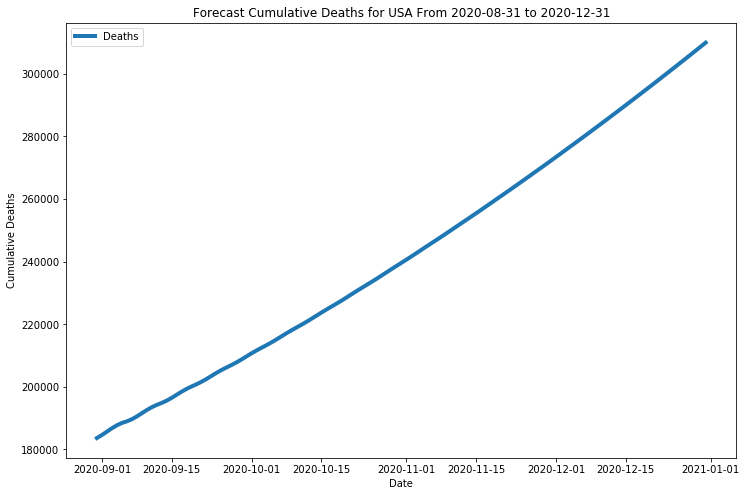

In [5]:
df.index = pd.to_datetime(df.index)
forecast_df = msf.driver(df, arg_dict)

If the arg_dict has a prediction date later than the above date, the reason is that ARIMA expects the jurisdiction to have no more instances by the date indicated. We truncate the prediction at that point. 

In [6]:
new_col = "Daily_" + arg_dict['dependent_variable']
df[new_col] = df[arg_dict['dependent_variable']] - df[arg_dict['dependent_variable']].shift()
print('Actual')
df.tail() 

Actual


,Deaths,Daily_Deaths
Date_,,
2020-08-26,179708.0,1222.0
2020-08-27,180824.0,1116.0
2020-08-28,181800.0,976.0
2020-08-29,182761.0,961.0
2020-08-30,183066.0,305.0


In [7]:
forecast_df[new_col] = forecast_df[arg_dict['dependent_variable']] - forecast_df[arg_dict['dependent_variable']].shift()
forecast_df.iloc[0,1] = forecast_df.iloc[0,0] - df.iloc[-1,0]
print('Predicted')
forecast_df.head()

Predicted


,Deaths,Daily_Deaths
Date_,,
2020-08-31,183661.0,595.0
2020-09-01,184614.0,953.0
2020-09-02,185702.0,1088.0
2020-09-03,186770.0,1068.0
2020-09-04,187717.0,947.0
